# Sensor Data Analysis for recognizing letters

Required packages for this notebook:

```
pip install matplotlib numpy ipympl ipywidgets
```

In [304]:
import dataclasses
import pathlib
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

## Data loading

In [305]:
@dataclasses.dataclass
class Recording:
  id: str
  gravity: np.ndarray
  quat: np.ndarray
  euler: np.ndarray

def loadData() -> List[Recording]:
  result = []
  root = pathlib.Path("2710//M2")
  for dir in root.glob("L_*"):
    gravity = loadNumeric(dir / "gravity_data.txt")
    quat = loadNumeric(dir / "quat_data.txt")
    euler = loadNumeric(dir / "euler_data.txt") # bearing roll tilt
    result.append(Recording(id=dir.name, gravity=gravity, quat=quat, euler=euler))
  return result

def loadNumeric(path: pathlib.Path) -> np.ndarray:
  rows = []
  for line in open(path, 'r'):
    if not line.strip():
      continue
    rows.append(np.array([float(v) for v in line.split()], np.float64))
  return np.stack(rows, axis=0)

recordings = loadData()

43


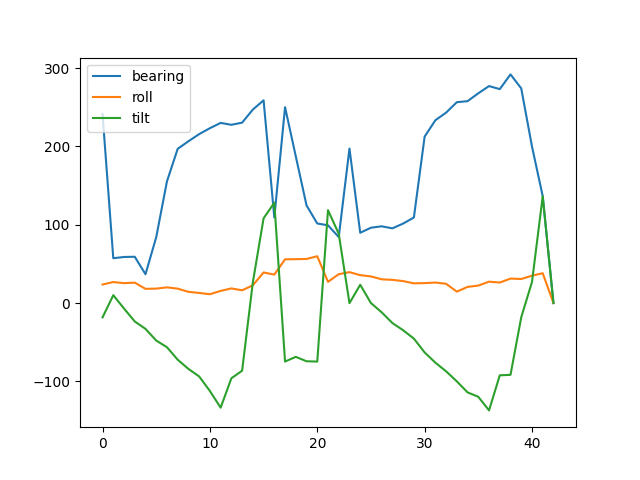

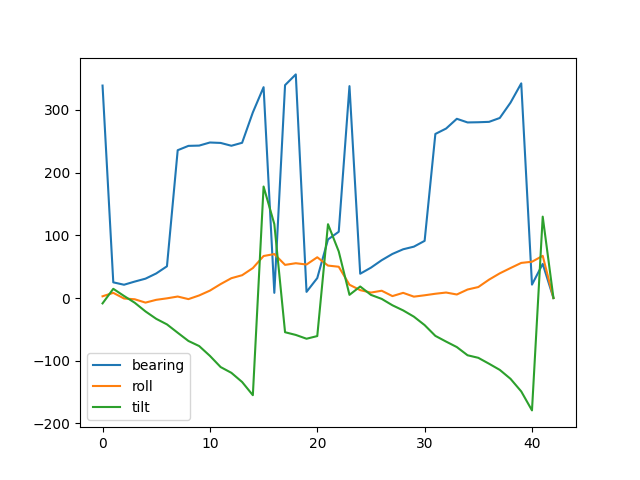

In [306]:
"""Euler is bearing, roll, tilt."""

def getEulers(recording: Recording):
  """Returns an Nx3 matrix of getEulers based on recording.getEulers."""
  # Direction of the wand tip relative to quat frame.
  # Chosen by trial and error to give positive Z values and clear shapes.
  # 1, 0, 0  works reasonably well too.
  # tip = np.array([0.8, -0.5, -0.4], dtype=np.float64)
  # tip /= np.linalg.norm(tip)

  # Drop first 10 entries as gravity is not calibrated
  eulers = recording.euler
  
  # print(eulers)

  # result = np.empty([quats.shape[0], 3], np.float64)
  # for i in range(quats.shape[0]):
  #   result[i, :] = applyRotation(quats[i, :], tip)

  return eulers


def plotNormalizedE(ax, eulers, name):
  """Euler is bearing, roll, tilt."""

  
  roll = np.mean(eulers[:,0])
  ax.plot(roll)
  # ax.scatter(x=yaw, y=pitch, alpha=0.2, label=name)


eulsArr = np.array(recordings)
nRecs = len(recordings)
print(nRecs)
# print("eulsArr shape = ")
# print(eulsArr.shape)

eulers1_fig = plt.figure("Mean Eulers")
eulers1_fig.clear()
ax1 = eulers1_fig.add_subplot()

eulers2_fig = plt.figure("Start Eulers")
eulers2_fig.clear()

ax2 = eulers2_fig.add_subplot()

# meansA = np.array([nRecs,3])

meansEA = np.zeros((nRecs, 3))
startsEA = np.zeros((nRecs, 3))  # start euler angle

for i, recording in enumerate(recordings[1:]):
  means = np.average(getEulers(recording),axis=0)
  starts = np.average(getEulers(recording)[1:2,:],axis=0)
  # print(meansA[i,:])  
  # print("x")  
  meansEA[i,:] = means
  startsEA[i,:] = starts
 
ax1.plot(meansEA)  
ax1.legend(['bearing', 'roll', 'tilt'])


ax2.plot(startsEA)  
ax2.legend(['bearing', 'roll', 'tilt'])





## Quaternion utilities

In [307]:
def mulQuat(q0, q1):
  """Multiply two quaternions."""
  w0 = q0[0]
  x0 = q0[1]
  y0 = q0[2]
  z0 = q0[3]

  w1 = q1[0]
  x1 = q1[1]
  y1 = q1[2]
  z1 = q1[3]

  return np.array([
    w0 * w1 - x0 * x1 - y0 * y1 - z0 * z1,
    w0 * x1 + x0 * w1 + y0 * z1 - z0 * y1,
    w0 * y1 - x0 * z1 + y0 * w1 + z0 * x1,
    w0 * z1 + x0 * y1 - y0 * x1 + z0 * w1,
  ])

def invQuat(q):
  """Invert a quaternion rotation (quat conjugate)."""
  return np.array([q[0], -q[1], -q[2], -q[3]])

def applyRotation(q, p):
  """Returns a position vector p, rotated by a unit quaternion rotation."""
  # p' = q * p * inv(q)
  return mulQuat(q, mulQuat(np.concatenate([[0], p]), invQuat(q)))[1:]

## Turning a sequence of orientations to a 3D trajectory

xx


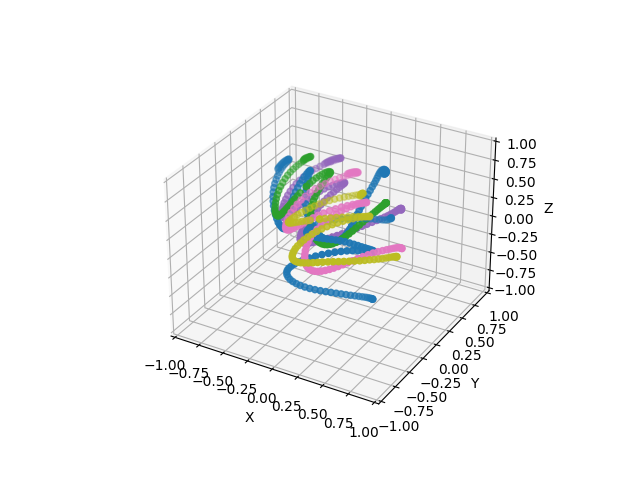

In [308]:
def get3DTipTrajectory(recording: Recording):
  """Returns an Nx3 matrix of positions based on recording.quat."""
  # Direction of the wand tip relative to quat frame.
  # Chosen by trial and error to give positive Z values and clear shapes.
  # 1, 0, 0  works reasonably well too.
  tip = np.array([0.8, -0.5, -0.4], dtype=np.float64)
  tip /= np.linalg.norm(tip)

  # Drop first 10 entries as gravity is not calibrated
  quats = recording.quat

  result = np.empty([quats.shape[0], 3], np.float64)
  for i in range(quats.shape[0]):
    result[i, :] = applyRotation(quats[i, :], tip)

  return result

def plot3DTrajectory(ax, trajectory):
  """Adds a 3D scatter plot of the trajectory to `ax`."""

  [l.remove() for l in ax.lines]
  xs = trajectory[:, 0]
  ys = trajectory[:, 1]
  zs = trajectory[:, 2]
  ax.scatter(xs, ys, zs, marker='o')
  ax.scatter([0], [0], [0], marker='x')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_xbound(-1, 1)
  ax.set_ybound(-1, 1)
  ax.set_zbound(-1, 1)


print("xx")

traj_fig = plt.figure('All Trajectories', clear=True)
traj_fig.clear()
traj_ax = traj_fig.add_subplot(projection='3d')

for recording in recordings[37:]:
  # print(len(recordings))
  plot3DTrajectory(traj_ax, get3DTipTrajectory(recording))


The previous cell shows that largely, we have decent trajectories, aligned with positive Z being upwards.

Now we want to project each trajectory into a small 2D image. The idea is to convert the trajectory back to Euler angles, find the smallest yaw and pitch ranges that encompass the whole trajectory, and treat those values as X and Y in the image space.

In [309]:
def yawAngles(trajectory):
  """Converts position on unit circle to yaw angles (longitude).
  
  Returns angles in [-pi, pi]."""
  # find the angle on the x-y plane.
  return np.arctan2(trajectory[:, 0], trajectory[:, 1])

def pitchAngles(trajectory):
  """Converts positions on unit circle to pitch angles (latitude).
  
  Returns angles in [-pi/2, pi/2]."""
  return np.arcsin(trajectory[:, 2])

def wrappingAngleRange(angles) -> Tuple[float, float]:
  """Returns the smallest angle range that encompasses all angles.
  
  Args:
    angles: array of radian angles in [-pi, pi].
  
  Returns:
    a tuple of two angles. If the second is smaller than the first, then the
    angle range contains pi.
  """
  # Algorithm: Find the largest gap between adjacent angles (handling the wrap-around
  # at pi), then return 2*pi minus that angle.
  angles = np.sort(angles)
  angles_diff = angles - np.roll(angles, 1)
  angles_diff[0] = 2*np.pi + angles_diff[0]
  first_angle = np.argmax(angles_diff)
  last_angle = (first_angle - 1) % angles.size
  return (angles[first_angle], angles[last_angle])

for i in range(len(recordings)):
  angle_range = wrappingAngleRange(yawAngles(get3DTipTrajectory(recordings[i])))
  print(i, "[%0.1f, %0.1f]" % (angle_range[0] * 180 / np.pi, angle_range[1] * 180 / np.pi))


0 [88.5, 134.3]
1 [92.8, 149.4]
2 [139.9, -178.7]
3 [138.0, -168.0]
4 [140.1, -157.0]
5 [134.3, -161.0]
6 [137.3, -153.9]
7 [139.8, -142.6]
8 [125.1, -138.9]
9 [123.5, -135.7]
10 [124.7, -138.9]
11 [55.7, -154.0]
12 [30.3, -160.4]
13 [42.7, -165.5]
14 [51.7, 162.3]
15 [62.4, 142.4]
16 [45.4, 135.5]
17 [57.3, 138.9]
18 [-90.7, -178.5]
19 [-91.3, -159.6]
20 [87.1, 48.1]
21 [-10.3, -77.6]
22 [125.7, -172.8]
23 [128.8, -173.0]
24 [94.9, 137.2]
25 [152.0, -160.6]
26 [165.6, -139.4]
27 [173.5, -132.9]
28 [175.5, -120.3]
29 [178.0, -111.1]
30 [-179.8, -110.2]
31 [165.5, -104.2]
32 [162.9, -90.4]
33 [166.3, -82.5]
34 [153.0, -74.8]
35 [47.5, -123.4]
36 [45.9, -104.7]
37 [59.8, -94.7]
38 [104.1, -85.3]
39 [96.1, 13.8]
40 [94.6, -177.8]
41 [115.3, -179.4]
42 [108.4, 173.4]


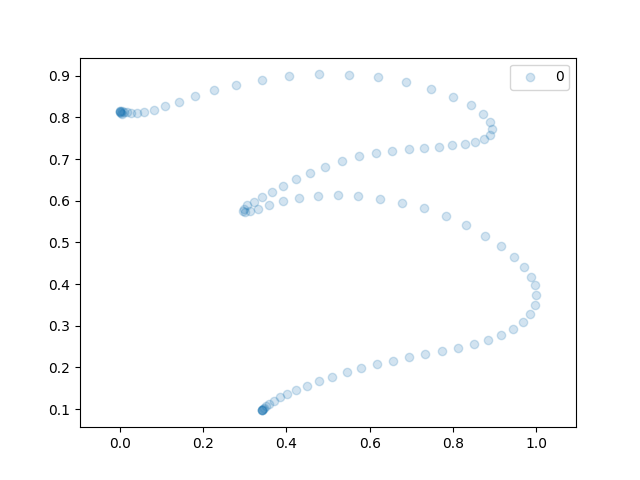

In [310]:
def normaliseTrajectory(trajectory):
  """Returns trajectory points as yaw and pitch angles, normalised to start at 0."""
  yaw = yawAngles(trajectory)
  pitch = pitchAngles(trajectory)
  yaw_range = wrappingAngleRange(yaw)
  # note: wrappingAngleRange would work for pitch, but we don't need it, since the
  # angles are in [-pi/2, pi/2] and don't wrap around
  pitch_range = (np.min(pitch), np.max(pitch))
  yaw -= yaw_range[0]
  yaw[yaw < 0] += 2 * np.pi
  pitch = pitch - pitch_range[0]
  pitch[pitch < 0] += 2 * np.pi

  return fitInBox(yaw, pitch)

def fitInBox(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """Rescales a set of x-y coordinates to fit in a 1x1 box."""
  min_x = np.min(x)
  x_range = np.max(x) - min_x
  min_y = np.min(y)
  y_range = np.max(y) - min_y
  scale = 1.0 / max(x_range, y_range)
  new_x = 0.5 + (x - min_x - x_range / 2) * scale
  new_y = 0.5 + (y - min_y - y_range / 2) * scale
  
  # print("new_x[0:15]",new_x[0:15])
  # print("new_y[0:15]",new_y[0:15])
  return new_x, new_y

def plotNormalized(ax, trajectory, name):
  yaw, pitch = normaliseTrajectory(trajectory)
  ax.scatter(x=yaw, y=pitch, alpha=0.2, label=name)

normalized_fig = plt.figure("norm")
normalized_fig.clear()
normalized_ax = normalized_fig.add_subplot()
for i, recording in enumerate(recordings[42:]):
  plotNormalized(normalized_ax, get3DTipTrajectory(recording), str(i))
  # break
normalized_ax.axis('equal')
normalized_ax.legend()

## Appendix: Data validation - understanding the gravity vector

Validate that gravity vectors are about 9.81 m/s^2 in magnitude.

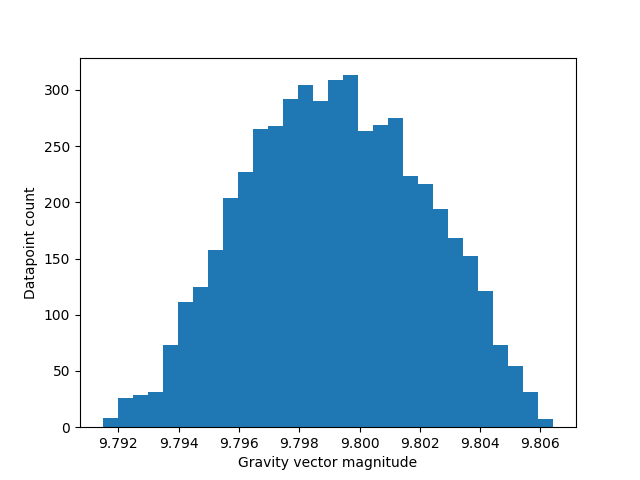

In [311]:
def gravityNormsHistogram(recordings):
  gravity_norms = np.concatenate(
    [np.linalg.norm(recording.gravity, axis=1) for recording in recordings])
  fig = plt.figure("gravity_norm")
  ax = fig.add_subplot()
  ax.hist(x=gravity_norms, bins=30)
  ax.set_xlabel("Gravity vector magnitude")
  ax.set_ylabel("Datapoint count")

gravityNormsHistogram(recordings)

John says each gravity list is missing the first 10 elements to align with quaternions. Verify:

In [312]:
def validateDimensions(recordings):
  for recording in recordings:
    g_dim = recording.gravity.shape[0]
    quat_dim = recording.quat.shape[0]
    if g_dim + 0 != quat_dim:
      raise ValueError(f"Recording {recording.id} has {g_dim} gravity readings and {quat_dim} quat entries")
validateDimensions(recordings)

Try averaging the gravity vectors. If they always point the same way between trajectories, we'd would expect the mean to have magnitude close to 9.81 m/s^2 (since we won't have destructive interference).

In [313]:
def meanGravity(recordings, firstn=None):
  if firstn:
    return np.mean(np.concatenate(
        [recording.gravity[:firstn, :] for recording in recordings], axis=0), axis=0)
  return np.mean(np.concatenate(
    [recording.gravity for recording in recordings], axis=0), axis=0)

print("Overall mean:", meanGravity(recordings), np.linalg.norm(meanGravity(recordings)))
print("First step mean:", meanGravity(recordings, 1), np.linalg.norm(meanGravity(recordings, 1)))

Overall mean: [ 4.35813349 -3.01349281  0.34654263] 5.309854824126306
First step mean: [ 3.62953488 -3.66348837  2.99255814] 5.962388342191775


Results show that the gravity vectors don't tend to be consistent between episodes. This could be due to differences in how the sensor is mounted, differences in how the wand is held, or a calibration issue.

Next: Find a relation between the quaternions and the gravity vector.

In [314]:
def rotatedGravity(recording: Recording, transpose: bool = False):
  quats = recording.quat
  result = np.empty([quats.shape[0], 3], np.float64)
  for i in range(quats.shape[0]):
    result[i, :] = applyRotation(quats[i, :], recording.gravity[i, :])

  return result

def meanRotatedGravity(recordings: List[Recording]) -> np.ndarray:
  return np.mean(np.concatenate([rotatedGravity(r) for r in recordings], axis=0), axis=0)

# Prints a vector like
# [[ 0.23779003]
#  [-0.37204996]
#  [ 9.7412319 ]]
# which suggests that:
# 1. This is the correct transformation (close to 9.81 in the same direction)
# 2. The base orientation has Z going downwards
print(meanRotatedGravity(recordings),
      np.linalg.norm(meanRotatedGravity(recordings)))

[ 1.15771764e-03 -6.69660063e-03  9.79476163e+00] 9.794763987794097


So now we have a way of taking a vector in the wand frame (e.g. gravity)
and getting a result in the world frame, but the world frame has positive Z going downwards.
We should be able to pick a point along the wand line (e.g. [1, 0, 0]), transform it with the
quaternions, and get its trajectory in the world frame.